In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
import torch.utils.data as data
from torchvision.utils import make_grid
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
trainTfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])
                         #tt.Normalize(*stats,inplace=True)])


In [2]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        # denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:


# variables
batchSize = 256

# folders and files
inputDataPath = "input/german-traffic-signs"
trainDataPath = inputDataPath + "/Train"
trainDataCsv = inputDataPath + "/Train.csv"
testDataPath = inputDataPath + "/Test"
testDataCsv = inputDataPath + "/Train.csv"

trainData = torchvision.datasets.ImageFolder(root=trainDataPath, transform=trainTfms)
valDataLen = 3000
trainDataLen = len(trainData) - valDataLen

trainData, valData = random_split(trainData, [trainDataLen, valDataLen])

trainDl = DataLoader(trainData, batch_size=batchSize, num_workers=3, pin_memory=True)
validDl = DataLoader(valData, batch_size=batchSize, num_workers=3, pin_memory=True)




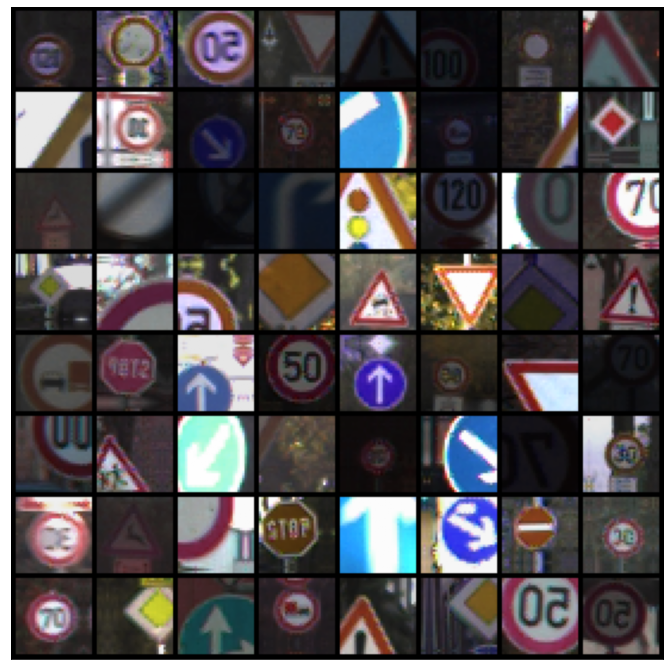

In [5]:
show_batch(trainDl)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

trainDl = DeviceDataLoader(trainDl, device)
validDl = DeviceDataLoader(validDl, device)

Using cuda device


In [7]:
class tsrNet(torchvision.models.resnet.ResNet):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        # return loss
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f},".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

    def __init__(self, num_classes):
        super().__init__(block=torchvision.models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes)
        
    def forward(self, xb):
        out = super().forward(xb)
        return out

model = to_device(tsrNet(43),device)
print(model)

tsrNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    train_history=[0]
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        train_history.append(result['train_acc'])
        model.epoch_end(epoch, result)
        history.append(result)
    return history, train_history

In [9]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
valid_history = [evaluate(model, validDl)]
train_history = []

one_valid_history, train_history = fit_one_cycle(epochs, max_lr, model, trainDl, validDl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)
valid_history += one_valid_history

Epoch [0], last_lr: 0.00043, train_loss: 2.7213, train_acc: 0.2319, val_loss: 2.3077, val_acc: 0.3238,
Epoch [1], last_lr: 0.00050, train_loss: 1.9541, train_acc: 0.4026, val_loss: 1.9721, val_acc: 0.4150,
Epoch [2], last_lr: 0.00063, train_loss: 1.5936, train_acc: 0.5003, val_loss: 1.7043, val_acc: 0.4673,
Epoch [3], last_lr: 0.00081, train_loss: 1.3640, train_acc: 0.5701, val_loss: 1.6189, val_acc: 0.5072,
Epoch [4], last_lr: 0.00104, train_loss: 1.2001, train_acc: 0.6176, val_loss: 1.5424, val_acc: 0.5229,
Epoch [5], last_lr: 0.00132, train_loss: 1.0856, train_acc: 0.6537, val_loss: 1.2146, val_acc: 0.6176,
Epoch [6], last_lr: 0.00163, train_loss: 0.9988, train_acc: 0.6830, val_loss: 1.2086, val_acc: 0.6208,
Epoch [7], last_lr: 0.00199, train_loss: 0.9055, train_acc: 0.7120, val_loss: 1.0352, val_acc: 0.6771,
Epoch [8], last_lr: 0.00238, train_loss: 0.8488, train_acc: 0.7312, val_loss: 1.0140, val_acc: 0.6726,
Epoch [9], last_lr: 0.00280, train_loss: 0.8078, train_acc: 0.7450, val_l

In [1]:
valid_accuracies = [x['val_acc'] for x in valid_history]
train_accuracies = [x for x in train_history]
plt.plot(valid_accuracies, '-x')
plt.plot(train_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('Accuracy vs. No. of epochs')

NameError: name 'valid_history' is not defined

Text(0.5, 1.0, 'Loss vs. No. of epochs')

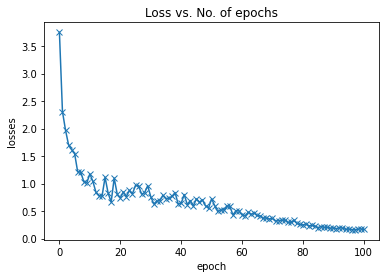

In [51]:
valid_loss = [x['val_loss'] for x in valid_history]
#train_loss = [x['train_loss'] for x in valid_history]
plt.plot(valid_loss, '-x')
#plt.plot(train_loss, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Loss vs. No. of epochs')

In [19]:
from PIL import Image

data_dir="input/german-traffic-signs/Test"
test_class=os.listdir(data_dir)

import pandas as pd
df = pd.read_csv(inputDataPath+"/Test.csv")
y_test=df['ClassId'].values
path_list =df['Path'].values

data=[]
for f in path_list:
    img = Image.open(inputDataPath+'/Test/'+f.replace('Test/', ''))
    data_array=tt.ToTensor()
    img_PIL = tt.Resize([32,32])(img)
    img_ = tt.ToTensor()(img_PIL)
    data.append(img_)

test_loader =DataLoader(data, batch_size=batchSize, shuffle=False)

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds.item()

total_true_predictions = 0
for i in range(len(data)):
    img= data[i]
    #plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
    if (y_test[i] == predict_image(img, model)):
        total_true_predictions += 1

In [21]:
print ("Total True Predictions = ", total_true_predictions)
print("Test accuracy = %", (100*total_true_predictions)/len(data))

Total True Predictions =  765
Test accuracy = % 6.0570071258907365
